In [1]:
!wget https://raw.githubusercontent.com/manthi4/GeneticTensor/main/b_functions.py
!wget https://raw.githubusercontent.com/manthi4/GeneticTensor/main/simulations.py

--2022-12-16 21:54:02--  https://raw.githubusercontent.com/manthi4/GeneticTensor/main/b_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2359 (2.3K) [text/plain]
Saving to: ‘b_functions.py’

b_functions.py      100%[===================>]   2.30K  --.-KB/s    in 0s      

2022-12-16 21:54:03 (24.2 MB/s) - ‘b_functions.py’ saved [2359/2359]

--2022-12-16 21:54:03--  https://raw.githubusercontent.com/manthi4/GeneticTensor/main/simulations.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8790 (8.6K) [text/plain]
Saving t

In [2]:
import numpy as np
from tqdm import tqdm
from simulations import *
from b_functions import *
import multiprocessing
import threading
from typing_extensions import DefaultDict


%matplotlib inline
# plt.rcParams["figure.figsize"] = (15,7)
multiprocessing.cpu_count()

2

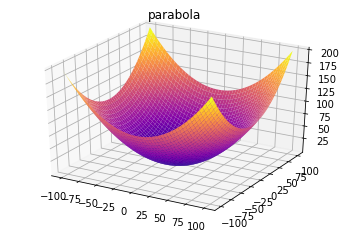

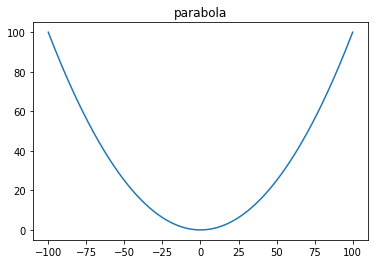

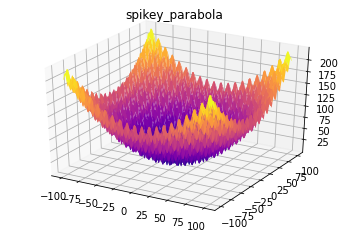

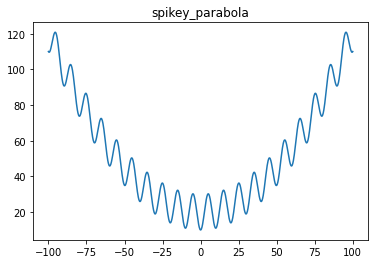

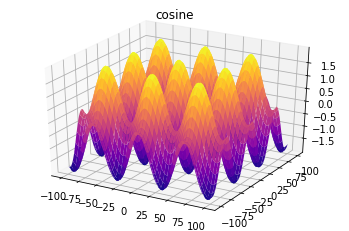

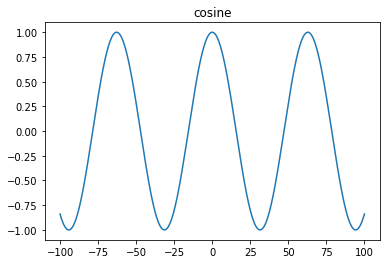

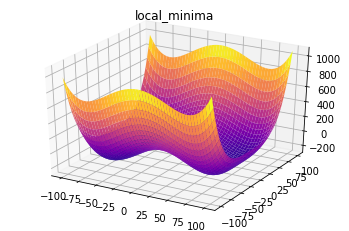

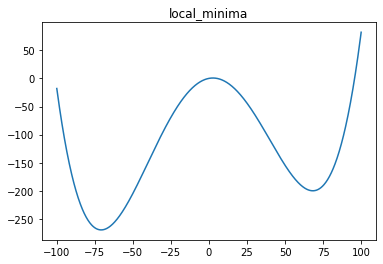

In [4]:
show_all()

Rough Parabola $  =  x^2 - 10cos(2\pi x)$


$N_t = c$

$σ^2_t = σ^2_{t-1}G$

$N_t = \frac{N_{t-1}}{G}$

$N_t = N_{t-1} - B$

$σ^2 = s$

$σ^2_t = max(10^{-14}, σ^2_{t-1} - B)$


In [ ]:
pop_search_space = np.linspace(30, 100, 15)
std_search_space = np.linspace(1, 50, 15)
pops, stds = np.meshgrid(pop_search_space, std_search_space)


In [ ]:
search_range = (-100, 100)
dim = 1
keep_n = lambda pop: len(pop) //4

reduction_sim = lambda p0_size, sigma: linear_population_fixed_std(search_range, dim, p0_size, keep_n_linear, sigma, parabola)
runs = 20
minimum = 0

def experiment(reduction_sim, runs, minimum):
  # num_threads = multiprocessing.cpu_count()
  times = np.zeros_like(pops)
  convergence = np.zeros_like(pops)

  for i in tqdm(range(len(pops))):
      for j in range(len(pops[i])):
          sigma = stds[i][j]
          p0_size = int(pops[i][j])
          global tt
          global c
          tt = 0
          c = 0
          lck = threading.Lock()

          def thread_fn():
            global tt
            global c
            pop_avg, _, _, t = reduction_sim(p0_size, sigma) #linear_population_fixed_std(search_range, dim, p0_size, keep_n_linear, sigma, parabola)
            lck.acquire()
            c += (minimum - np.mean(pop_avg[-5:]))**2
            tt += t
            lck.release()
          
          worker_threads = [threading.Thread(target= thread_fn, args=()) for it in range(runs)]

          for t in worker_threads:
            # print("running thread ", t)
            t.start()

          for t in worker_threads:
            t.join()

          times[i, j] = tt/runs
          convergence[i, j] = float(c/runs)
  return times, convergence


In [ ]:
geom_test_vals = [ 4, 4.5, 5]
runs = 4

def geom_population_g_search(geom_test_vals, runs, dim):
    search_range = (-100, 100)
    output_times = DefaultDict(lambda : [])
    output_errors = DefaultDict(lambda : [])
    for g in geom_test_vals:
      keep_n_geom = lambda pop: int(max(1, len(pop) //g))
      for n, fn in func_list.items():
        reduction_sim = lambda p0_size, sigma: geom_population_fixed_std(search_range, dim, p0_size, keep_n_geom, sigma, fn)
        minimum = min_list[n]
        times, convergence = experiment(reduction_sim, runs, minimum)
        output_times[n] += [np.mean(times)]
        output_errors[n] += [np.mean(convergence)]
        print(f"g: {g}\tfunc: {n}\t {np.mean(times)}, {np.mean(convergence)}")
    return output_times, output_errors, geom_test_vals

In [ ]:

def linear_population_b_search(linear_test_vals, runs, dim):
    search_range = (-100, 100)
    output_times = DefaultDict(lambda : [])
    output_errors = DefaultDict(lambda : [])
    for b in linear_test_vals:
      keep_n_linear = lambda pop: max(1, (len(pop)-b)//2)
      for n, fn in func_list.items():
        reduction_sim = lambda p0_size, sigma: linear_population_fixed_std(search_range, dim, p0_size, keep_n_linear, sigma, fn)
        minimum = min_list[n]
        times, convergence = experiment(reduction_sim, runs, minimum)
        output_times[n] += [np.mean(times)]
        output_errors[n] += [np.mean(convergence)]
        print(f"g: {b}\tfunc: {n}\t {np.mean(times)}, {np.mean(convergence)}")
    return output_times, output_errors, geom_test_vals

In [ ]:
geom_test_vals = [ .9, .8, .7, .5, .25]

def geom_std_g_search(geom_test_vals, runs, dim):
    search_range = (-100, 100)
    output_times = DefaultDict(lambda : [])
    output_errors = DefaultDict(lambda : [])
    for g in geom_test_vals:
      for n, fn in func_list.items():
        reduction_sim = lambda p0_size, sigma: fixed_population_geom_std(search_range, dim, p0_size, sigma, g, fn)
        minimum = min_list[n]
        times, convergence = experiment(reduction_sim, runs, minimum)
        output_times[n] += [np.mean(times)]
        output_errors[n] += [np.mean(convergence)]
        print(f"g: {g}\tfunc: {n}\t {np.mean(times)}, {np.mean(convergence)}")
    return output_times, output_errors, geom_test_vals

In [ ]:
linear_test_vals = [1, 5, 10, 20]

def linear_std_g_search(linear_test_vals, runs, dim):
    search_range = (-100, 100)
    output_times = DefaultDict(lambda : [])
    output_errors = DefaultDict(lambda : [])
    for b in linear_test_vals:
      for n, fn in func_list.items():
        reduction_sim = lambda p0_size, sigma: fixed_population_linear_std(search_range, dim, p0_size, sigma, b, fn)
        minimum = min_list[n]
        times, convergence = experiment(reduction_sim, runs, minimum)
        output_times[n] += [np.mean(times)]
        output_errors[n] += [np.mean(convergence)]
        print(f"g: {b}\tfunc: {n}\t {np.mean(times)}, {np.mean(convergence)}")
    return output_times, output_errors, linear_test_vals

In [ ]:
1e-13

1e-13

In [ ]:
linear_test_vals = [1, 5, 10, 20]
# geom_test_vals = [.5, .25]

runs = 4
dim = 1
output_times, output_errors, geom_test_vals = linear_std_g_search(linear_test_vals, runs, dim)

100%|██████████| 15/15 [01:00<00:00,  4.04s/it]


g: 1	func: parabola	 0.23837965461942884, 0.534740381053337


100%|██████████| 15/15 [01:10<00:00,  4.72s/it]


g: 1	func: spikey_parabola	 0.28116291284561157, 7.833562069121419


100%|██████████| 15/15 [00:45<00:00,  3.04s/it]


g: 1	func: cosine	 0.16490665409300062, inf


100%|██████████| 15/15 [02:53<00:00, 11.55s/it]


g: 1	func: local_minima	 0.6417613771226671, 19.16615552502222


100%|██████████| 15/15 [02:32<00:00, 10.13s/it]


g: 5	func: parabola	 0.6521291624175177, 1.4341481151663464


100%|██████████| 15/15 [02:58<00:00, 11.89s/it]


g: 5	func: spikey_parabola	 0.7590214623345269, 18.189231922003465


100%|██████████| 15/15 [02:12<00:00,  8.86s/it]


g: 5	func: cosine	 0.5208829071786668, inf


100%|██████████| 15/15 [05:15<00:00, 21.04s/it]


g: 5	func: local_minima	 1.1163839048809476, 18.517224359170434


100%|██████████| 15/15 [02:34<00:00, 10.27s/it]


g: 10	func: parabola	 0.6690278606944614, 1.986078113608845


100%|██████████| 15/15 [03:02<00:00, 12.16s/it]


g: 10	func: spikey_parabola	 0.79321262439092, 30.67221265499716


100%|██████████| 15/15 [02:20<00:00,  9.33s/it]


g: 10	func: cosine	 0.5686471549669901, inf


100%|██████████| 15/15 [06:56<00:00, 27.77s/it]


g: 10	func: local_minima	 1.408980865213606, 19.626257435466552


100%|██████████| 15/15 [02:35<00:00, 10.34s/it]


g: 20	func: parabola	 0.6731814360618591, 3.6159561057132144


100%|██████████| 15/15 [03:02<00:00, 12.17s/it]


g: 20	func: spikey_parabola	 0.7927339990933736, 52.651077293582034


100%|██████████| 15/15 [02:26<00:00,  9.80s/it]


g: 20	func: cosine	 0.6183688547876146, inf


100%|██████████| 15/15 [09:10<00:00, 36.72s/it]

g: 20	func: local_minima	 1.9819100573327806, 22.318928023211402


In [ ]:
output_errors.pop('cosine')
output_times, output_errors, geom_test_vals

(defaultdict(<function __main__.linear_std_g_search.<locals>.<lambda>()>,
             {'parabola': [0.23837965461942884,
               0.6521291624175177,
               0.6690278606944614,
               0.6731814360618591],
              'spikey_parabola': [0.28116291284561157,
               0.7590214623345269,
               0.79321262439092,
               0.7927339990933736],
              'cosine': [0.16490665409300062,
               0.5208829071786668,
               0.5686471549669901,
               0.6183688547876146],
              'local_minima': [0.6417613771226671,
               1.1163839048809476,
               1.408980865213606,
               1.9819100573327806]}),
 defaultdict(<function __main__.linear_std_g_search.<locals>.<lambda>()>,
             {'parabola': [0.534740381053337,
               1.4341481151663464,
               1.986078113608845,
               3.6159561057132144],
              'spikey_parabola': [7.833562069121419,
               18.1892319

In [ ]:
def standardize(x):
  return np.divide( x ,max(x))

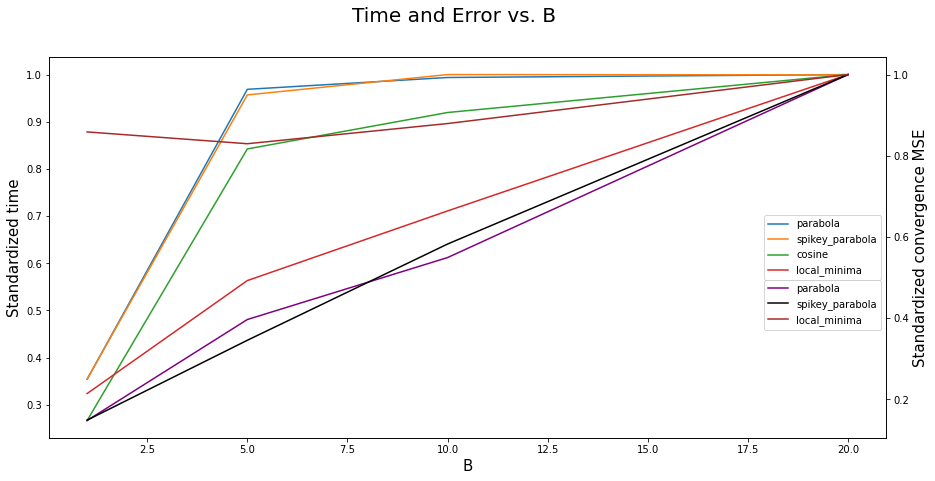

In [ ]:
g = linear_test_vals
fig, ax1 = plt.subplots()


for name, times in output_times.items():
  ax1.plot(g, standardize(times), label = f"{name}_time")
# ax1.plot(g, standardize(lm_t), label = "Local Min Time")
# ax1.plot(g, standardize(rp_t), label = "Rough parabola Time")
# ax1.plot(g, standardize(c_t), label = "Cosine Time")

ax2 = ax1.twinx()
colors = ['purple', 'black', 'brown']
for (name, errors), co in zip(output_errors.items(), colors):
  ax2.plot(g, standardize(errors), label = f"{name}_error", c = co)
# ax2.plot(g, standardize(rp_e), label = "Rough parabola error", c = 'black')
# ax2.plot(g, standardize(lm_e), label = "Local Min error", c = 'brown')

ax1.legend(loc = 7)
ax2.legend(loc = 10, bbox_to_anchor=(0.924, 0.35))
fig.suptitle("Time and Error vs. B", fontsize = 20)
ax1.set_xlabel("B", fontsize = 15)
ax1.set_ylabel("Standardized time", fontsize = 15)
ax2.set_ylabel("Standardized convergence MSE", fontsize = 15)

plt.show()

In [ ]:
times, convergence = experiment(reduction_sim, 2, minimum)

100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


Text(0.5, 1.0, 'population vs time')

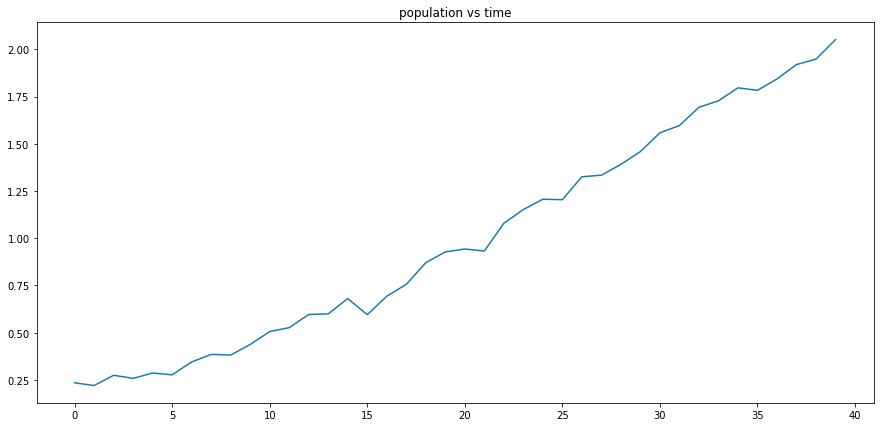

In [ ]:
plt.plot(np.sum(times, axis=-2))
plt.title("population vs time")

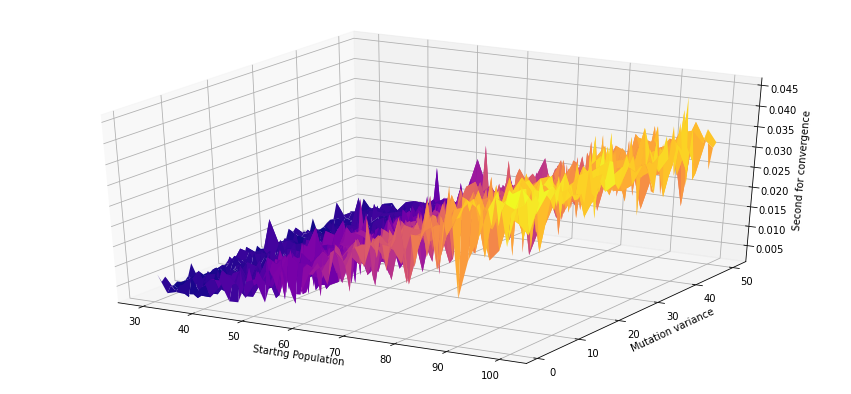

Text(0.5, 0, 'Convergence')

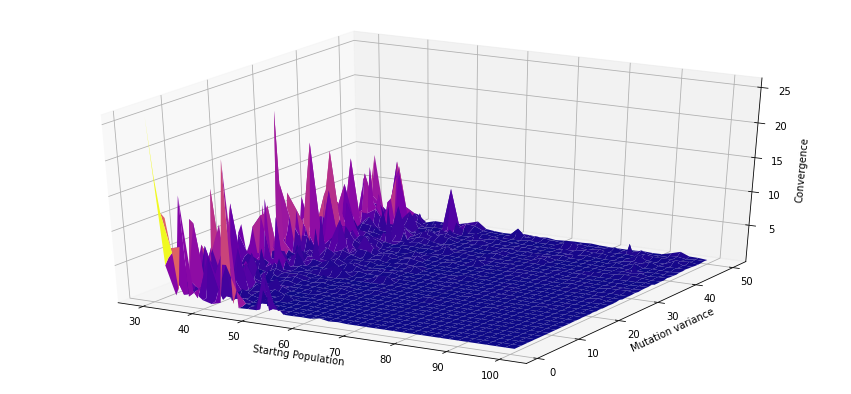

In [ ]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_surface(pops, stds, times, cmap='plasma')
ax.set_ylabel("Mutation variance")
ax.set_xlabel("Startng Population")
ax.set_zlabel("Second for convergence")

plt.show()
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_surface(pops, stds, convergence, cmap='plasma')
ax.set_ylabel("Mutation variance")
ax.set_xlabel("Startng Population")
ax.set_zlabel("Convergence")

In [ ]:
# geom pop
p_t = [0.0244,
       0.0166,
0.0139,
0.0113,
0.0107,
0.0102]
p_e = [
    8.6,
19.13,
24.58,
25.2,
28.33,
30.76,
]
rp_t = [
0.0289,
0.0189,
0.0156,
0.01238,
0.0113,
0.0104]

rp_e = [
    79.5,
155.6,
179.3,
186.11,
202.31,
206.35
]
c_t = [
    0.0225,
0.015,
0.0125,
0.009,
0.009,
0.009,
]
lm_t = [
    0.1439,
0.0962,
0.0747,
0.0568,
0.0512,
0.048,
]
lm_e = [37.59,
73.98,
114.11,
97.4,
138.91,
108.58
]

In [ ]:
# geom pop
p_t = [0.034,
       0.021,
0.013,
0.009,
0.008]
p_e = [
    8.6,
16.3,
25.8,
35.2,
40.06,
]
rp_t = [
0.040,
0.025,
0.015,
0.010,
0.008]

rp_e = [
    77.1,
131.6,
183.15,
217.63,
245.3
]
c_t = [
    0.031,
0.019,
0.011,
0.008,
0.007,
]
lm_t = [
    0.197,
0.122,
0.068,
0.045,
0.034
]
lm_e = [45.16,
60.32,
117.87,
176.89,
187.80
]

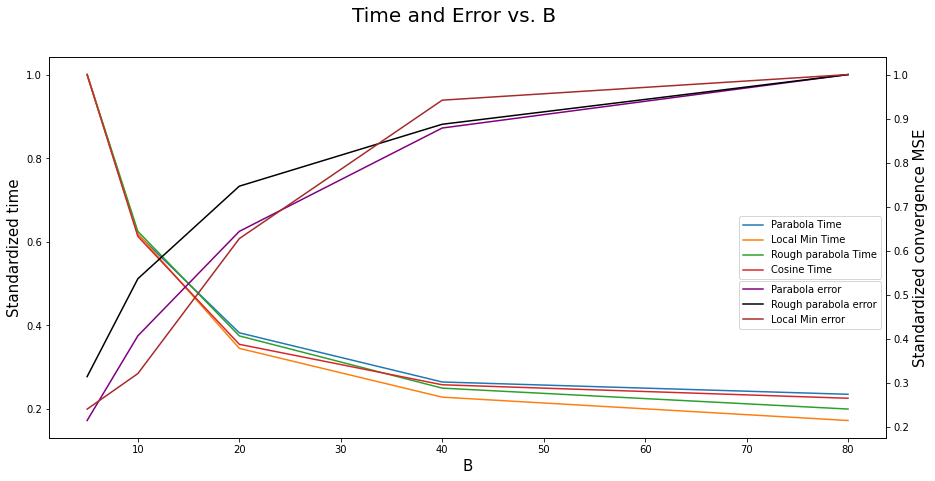

In [ ]:
g = [5, 10, 20, 40, 80]#np.linspace(2.5, 5, 6)
fig, ax1 = plt.subplots()

ax1.plot(g, standardize(p_t), label = "Parabola Time")
ax1.plot(g, standardize(lm_t), label = "Local Min Time")
ax1.plot(g, standardize(rp_t), label = "Rough parabola Time")
ax1.plot(g, standardize(c_t), label = "Cosine Time")

ax2 = ax1.twinx()
ax2.plot(g, standardize(p_e), label = "Parabola error", c = 'purple')
ax2.plot(g, standardize(rp_e), label = "Rough parabola error", c = 'black')
ax2.plot(g, standardize(lm_e), label = "Local Min error", c = 'brown')

ax1.legend(loc = 7)
ax2.legend(loc = 10, bbox_to_anchor=(0.909, 0.35))
fig.suptitle("Time and Error vs. B", fontsize = 20)
ax1.set_xlabel("B", fontsize = 15)
ax1.set_ylabel("Standardized time", fontsize = 15)
ax2.set_ylabel("Standardized convergence MSE", fontsize = 15)

plt.show()

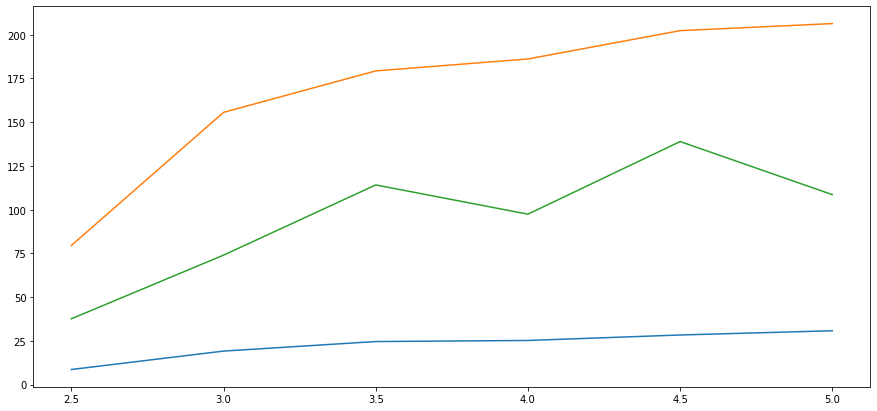

In [ ]:
plt.plot(g, p_e)
plt.plot(g, rp_e)
plt.plot(g, lm_e)